# Fluid Dynamics

**Author:** Gavin DeBrun

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib.animation import FuncAnimation
import itertools
from IPython.display import HTML
import pickle
def resetMe(keepList=[]):
    ll=%who_ls
    keepList=keepList+['resetMe','np','plt','math','FuncAnimation',
                       'HTML','itertools','pickle','testFunc']
    for iiii in keepList:
        if iiii in ll:
            ll.remove(iiii)
    for iiii in ll:
        jjjj="^"+iiii+"$"
        %reset_selective -f {jjjj}
    ll=%who_ls
    return

def testFunc(func,inFiles,outFiles):
    inputs  = [pickle.load(open(f,"rb")) for f in inFiles]
    outputs = [pickle.load(open(f,"rb")) for f in outFiles]
    result  = func(*inputs)
    allGood = True
    if not isinstance(result, tuple): result = (result,)
    for i in range(len(outputs)):
        if np.max(np.abs(result[i]-outputs[i])) > 1e-14:
            print("Failed test for",outFiles[i],i,"max_error=",np.max(np.abs(result[i]-outputs[i])))
            allGood = False
    if allGood: print("Test Passed!")
    else:       print("Test Failed :(")

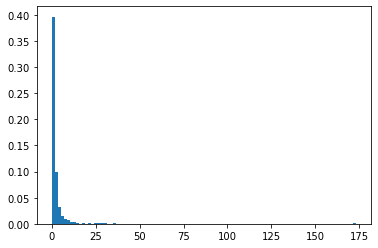

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def f():
  r1 = 1
  r2 = 1
  while (r1**2 + r2**2 <= 0 or r1**2 + r2**2 >= 1):
    r1 = np.random.random()
    r2 = np.random.random()
  s = r1**2 + r2**2
  return (r1/s) * (-2*np.log(s))**.5

numbers = []
for i in range(1000):
  numbers.append(f())

plt.hist(numbers,100, density = 1)
plt.show()

In [3]:
!wget https://courses.physics.illinois.edu/phys246/fa2020/code/TestFiles.zip && unzip TestFiles.zip

--2021-02-28 15:26:30--  https://courses.physics.illinois.edu/phys246/fa2020/code/TestFiles.zip
Resolving courses.physics.illinois.edu (courses.physics.illinois.edu)... 130.126.151.14
Connecting to courses.physics.illinois.edu (courses.physics.illinois.edu)|130.126.151.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53041362 (51M) [application/x-zip-compressed]
Saving to: ‘TestFiles.zip’

TestFiles.zip       100%[===================>]  50.58M  1.04MB/s    in 51s     

2021-02-28 15:27:22 (1019 KB/s) - ‘TestFiles.zip’ saved [53041362/53041362]

Archive:  TestFiles.zip
  inflating: Microscopic_after_move.dat  
  inflating: Microscopic.dat         
  inflating: rho_after_Micro2Macro.dat  
  inflating: Microscopic_after_bounce.dat  
  inflating: Microscopic2.dat        
  inflating: Microscopic_after_moveDensity.dat  
  inflating: Microscopic_after_boundary.dat  
  inflating: u_after_Micro2Macro.dat  
  inflating: Microscopic_after_collision.dat  
  inflating: 

In [4]:
### global variables and functions  
### function-cell - put everything in here!
nx=520; ny=180 #size of our simulation
obstacle = np.empty((nx,ny), dtype = 'bool')
obstacle[:,:] = False
v=np.zeros((9,2),dtype='int')
v[0,:]=[0,0]
v[1,:]=[0,1]
v[2,:]=[0,-1]
v[3,:]=[1,0]
v[4,:]=[-1,0]
v[5,:]=[-1,-1]
v[6,:]=[-1,1]
v[7,:]=[1,-1]
v[8,:]=[1,1]
n=np.zeros((9,nx,ny))

def GenerateCylinderObstacle():
  obstacles = obstacle.copy()
  for i in range(len(obstacles[:,0])):
    for j in range(len(obstacles[:,1])):
      if np.sqrt((i - nx/4)**2 + (j-ny/2)**2) < ny/9:
        obstacles[i, j] = True
  return obstacles

def Micro2Macro(n):
  voxels = n.copy()
  density = np.sum(voxels,axis=0)
  uy = (voxels[1,:,:] + voxels[6,:,:] + voxels[8,:,:] - voxels[2,:,:] - voxels[5,:,:] - voxels[7,:,:])/density
  ux = (voxels[3,:,:] + voxels[7,:,:] + voxels[8,:,:] - voxels[4,:,:] - voxels[5,:,:] - voxels[6,:,:])/density
  #print(voxels)
  u = (ux, uy)
  return density,u

def Macro2Equilibrium(rho, u):
  x = u
  w = [4/9,1/9,1/9,1/9,1/9,1/36,1/36,1/36,1/36]
  neq = []
  for i in range(9):
    n_val = w[i]*rho*( 1 + 3*(v[i,0]*x[0] + v[i,1]*x[1]) + 4.5*(v[i,0]*x[0] + v[i,1]*x[1])**2 - 1.5*(x[0]*x[0] + x[1]*x[1]))
    neq.append(n_val)
  return np.array(neq)

def Collision(n, obstacle):
  x = n.copy()
  rho,u = Micro2Macro(x)
  neq = Macro2Equilibrium(rho,u)
  omega = 1.9572953736654806
  nout = x * (1 - omega) + omega * neq
  obstacles = obstacle.copy()
  for i in range(n.shape[0]):
    nout[i,obstacle] = x[i,obstacle]
  return nout

def Bounce(n,obstacle):
  x = n.copy()
  obstacles = obstacle.copy()
  n[2,obstacles] = n[1,obstacles]
  n[1,obstacles] = x[2,obstacles]

  n[4,obstacles] = n[3,obstacles]
  n[3,obstacles] = x[4,obstacles]

  n[7,obstacles] = n[6,obstacles]
  n[6,obstacles] = x[7,obstacles]

  n[8,obstacles] = n[5,obstacles]
  n[5,obstacles] = x[8,obstacles]
  return n

def MoveDensity(n):
  n_new = n.copy()
  for i in range(0,9):
    n_new[i] = np.roll(n[i],v[i],(0,1))
  return n_new

def Move(n, obstacle):
  x = Bounce(n, obstacle)
  new = MoveDensity(x)
  return new

def FixBoundary(n, n_init):
  nout = n.copy()
  leftVelocities = [4,5,6]
  for i in leftVelocities:
    nout[i,-1,:] = nout[i,-2,:]
  nout[:,0, :] = n_init[:,0, :]
  return nout

def Setup():
  rho = np.ones((nx,ny))
  u = np.zeros((2,nx,ny))
  for i in range(nx):
    for j in range(ny):
      u[0,i,j] = 0.04*(1.0+1e-4*np.sin(j/(ny)*2*np.pi))
  neq = Macro2Equilibrium(rho, u)
  return neq

### a.  Making some obstacles

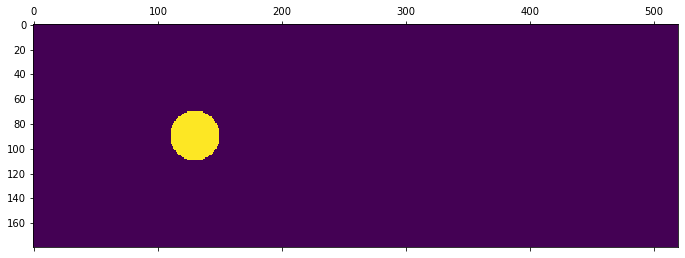

In [5]:
plt.matshow(GenerateCylinderObstacle().transpose())
plt.show()     

## b.  Microscopic velocities $v_i$

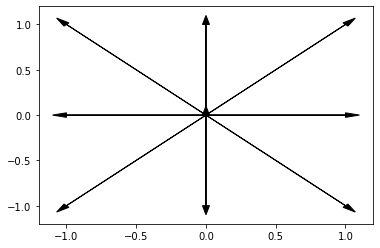

In [6]:
for i in range(0,9):
    plt.arrow(0,0,v[i,0],v[i,1],head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.show()

### c. Computing macroscopic quantities from the microscopic density

In [7]:
testFunc(Micro2Macro,["Microscopic.dat"],["rho_after_Micro2Macro.dat","u_after_Micro2Macro.dat"])

Test Passed!


### d. Getting the equilibrium microscopic densities. 

In [9]:
testFunc(Macro2Equilibrium,["rho_after_Micro2Macro.dat","u_after_Micro2Macro.dat"],["Microscopic_after_equilibrium.dat"])

Test Passed!


### d. Implementing collision

In [10]:
testFunc(lambda x: Collision(x,GenerateCylinderObstacle()),["Microscopic.dat"],["Microscopic_after_collision.dat"])

Test Passed!


### e. Moving

In [11]:
def Bounce(n,obstacle):
  x = n.copy()
  obstacles = obstacle.copy()
  n[2,obstacles] = n[1,obstacles]
  n[1,obstacles] = x[2,obstacles]

  n[4,obstacles] = n[3,obstacles]
  n[3,obstacles] = x[4,obstacles]

  n[7,obstacles] = n[6,obstacles]
  n[6,obstacles] = x[7,obstacles]

  n[8,obstacles] = n[5,obstacles]
  n[5,obstacles] = x[8,obstacles]
  return n
  
  

testFunc(lambda x: Bounce(x,GenerateCylinderObstacle()),["Microscopic.dat"],["Microscopic_after_bounce.dat"])

Test Passed!


In [12]:
testFunc(MoveDensity,["Microscopic.dat"],["Microscopic_after_moveDensity.dat"])

Test Passed!


In [13]:
testFunc(lambda x: Move(x,GenerateCylinderObstacle()),["Microscopic.dat"],["Microscopic_after_move.dat"])

Test Passed!


### f.  Boundary conditions

In [14]:
testFunc(FixBoundary,["Microscopic.dat","Microscopic2.dat"], ["Microscopic_after_boundary.dat"])

Test Passed!


### g. Setting up the initial conditions

All good? True


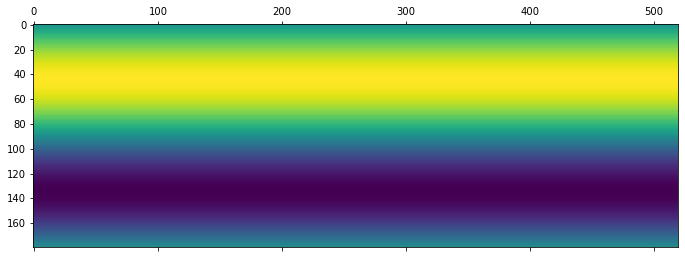

In [15]:
print("All good?",(np.abs(np.max(Setup())-0.443377991)<1e-5) and ((np.abs(np.min(Setup())-0.0245774711)<1e-5)))
plt.matshow(Setup()[3].transpose())
plt.show()

### h. Putting it all together

In [39]:
def Step(n, n_init, obstacle):
  nout = FixBoundary(n, n_init)
  nout = Collision(nout, obstacle)
  nout = Move(nout, obstacle)
  return nout
def Run(steps,record,n,n_init,obstacle):
  us = []
  rhos = []
  nout = n.copy()
  for i in range (0,steps):
    nout = Step(nout,n_init,obstacle)
    if (i%record) == 1:
      rho,u = Micro2Macro(nout)
      u2 = (np.sqrt(u[0]*u[0]+u[1]*u[1]))
      us.append(u2.transpose())
      rhos.append(rho)
  return rhos,us,nout

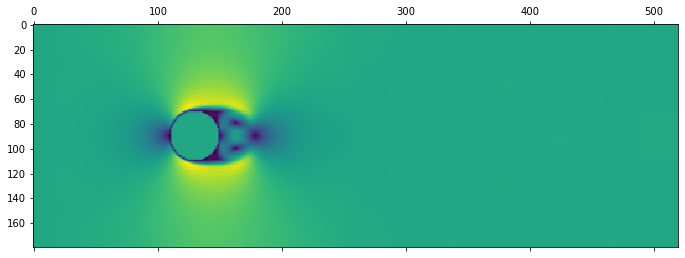

In [50]:
rhos, us, n = Run(2000, 20, Setup(), Setup(), GenerateCylinderObstacle())
plt.matshow(us[-1])
plt.show()

### i. Animation

🦉Now write a function `AnimateMe(us_flat,vMax)` which is going to take a list of velocities `us_flat` (and maximum for the `vMax`) and going to return an animation which is going to be then produced by calling 
```python
anim = AnimateMe(us,vMax)
HTML(anim.to_jshtml())
```

This function will look like:
```python
def AnimateMe(us_flat,vMax):
    fig, ax = plt.subplots()
    cax = ax.imshow(us_flat[1],cmap=plt.cm.Reds,vmin=0,vmax=vMax)
    plt.close(fig)
    def animate(i):
         cax.set_array(us_flat[i])

    anim = FuncAnimation(fig, animate, interval=100, frames=len(us_flat))
    return anim
```



In [51]:
def AnimateMe(us_flat,vMax):
    fig, ax = plt.subplots()
    cax = ax.imshow(us_flat[1],cmap=plt.cm.Reds,vmin=0,vmax=vMax)
    plt.close(fig)
    def animate(i):
         cax.set_array(us_flat[i])
 
    anim = FuncAnimation(fig, animate, interval=100, frames=len(us_flat))
    return anim
anim = AnimateMe(us,.07)
HTML(anim.to_jshtml())